In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
latex_labels = ['\\mathcal{O}_1', '\\mathcal{O}_2', '\\mathcal{O}_3', '\\mathcal{O}_1\'', '\\mathcal{O}_2\'']
colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]
ainv_list = [ainv_24I, ainv_24I, ainv_32I, ainv_32I, ainv_32I]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

In [4]:
print('a for 24I lattices: ' + str(hbarc / ainv_24I[0]) + ' fm')
print('a for 32I lattices: ' + str(hbarc / ainv_32I[0]) + ' fm')

a for 24I lattices: 0.11060874439461883 fm
a for 32I lattices: 0.08284047019311502 fm


### Renormalize bare matrix elements in NPR basis

In [5]:
# get RCs for Z_ij / Z_V^2 and Z_A
rc_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/Z_pert_run.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/Z_pert_run.h5']
fRCs = [h5py.File(path, 'r') for path in rc_paths]
ZijZVsq_24I_NPR = fRCs[0]['MSbar'][()]    # (ens_idx, boot_idx, i, j) in NPR basis
ZijZVsq_32I_NPR = fRCs[1]['MSbar'][()]
[f.close() for f in fRCs]

ZA_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5']
fZAs = [h5py.File(path, 'r') for path in ZA_paths]
ZA_24I = fZAs[0]['ZA'][()]    # (ens_idx, boot_idx)
ZA_32I = fZAs[1]['ZA'][()]
[f.close() for f in fZAs]

[None, None]

In [6]:
k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], dtype = np.float64) / 4.0
kinv = np.linalg.inv(k)
ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# get mean and std for 32I to generate fake data for ml0p008
Z32I_mu_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z32I_std_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z_32Iml0p008 = np.zeros((n_boot, n_ops, n_ops), dtype = np.float64)
for i in range(n_ops):
    for j in range(n_ops):
        tmp = Superboot(2)
        tmp.boots = ZijZVsq_32I_BSM[:, :, i, j]
        Z32I_mu_BSM[i, j] = tmp.compute_mean()
        Z32I_std_BSM[i, j] = tmp.compute_std()
        Z_32Iml0p008[:, i, j] = gen_fake_ensemble([Z32I_mu_BSM[i, j], Z32I_std_BSM[i, j]], n_samples = n_boot)
ZijZVsq_BSM = np.zeros((n_ens, n_boot, n_ops, n_ops), dtype = np.float64)
ZijZVsq_BSM[0] = ZijZVsq_24I_BSM[1]    # 24I/ml0p01
ZijZVsq_BSM[1] = ZijZVsq_24I_BSM[0]    # 24I/ml0p005
ZijZVsq_BSM[2] = Z_32Iml0p008    # 32I/ml0p008
ZijZVsq_BSM[3] = ZijZVsq_32I_BSM[1]    # 32I/ml0p006
ZijZVsq_BSM[4] = ZijZVsq_32I_BSM[0]    # 32I/ml0p004
ZA = np.zeros((n_ens, n_boot), dtype = np.float64)
ZA[0] = ZA_24I[0]
ZA[1] = ZA_24I[1]
ZA[2] = ZA_32I[0]
ZA[3] = ZA_32I[1]
ZA[4] = ZA_32I[2]

In [7]:
# select the renormalization coeffs to use
Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)
# Zij_BSM = ZijZVsq_BSM

# Uncomment here if we want to run bare matrix elements
# Zij_BSM = np.zeros((5, 50, 5, 5), dtype = np.float64)
# for a in range(n_ens):
#     for b in range(n_boot):
#         Zij_BSM[a, b] = np.eye(5)

In [8]:
# get final mean and std for each Zij coefficient. Use for each lattice spacing
# TODO if we get the data for the final lattice spacing, add it into 32I
Zij_BSM_24I = np.array([
    np.mean(Zij_BSM[:2], axis = (0, 1)), 
    np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
])
Zij_BSM_32I = np.array([
    np.mean(Zij_BSM[2:4], axis = (0, 1)), 
    np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
])
Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [9]:
print('24I renormalization:\n' + str(Zij_BSM_24I[0]))
print('Error:\n' + str(Zij_BSM_24I[1]))
print(export_matrix_latex(Zij_BSM_24I[0], Zij_BSM_24I[1]))

24I renormalization:
[[ 0.61248736  0.          0.         -0.07229296  0.        ]
 [ 0.          0.53667999  0.          0.         -0.02895547]
 [ 0.          0.          0.53354813  0.          0.        ]
 [-0.06237805  0.          0.          0.57721769  0.        ]
 [ 0.          0.01487703  0.          0.          0.67536391]]
Error:
[[0.00072959 0.         0.         0.00022076 0.        ]
 [0.         0.00089293 0.         0.         0.00022316]
 [0.         0.         0.0007474  0.         0.        ]
 [0.00021716 0.         0.         0.00096925 0.        ]
 [0.         0.00018815 0.         0.         0.00078315]]
\begin{pmatrix} 0.61249(73) & 0 & 0 & -0.07229(22) & 0 \\ 0 & 0.53668(89) & 0 & 0 & -0.02896(22) \\ 0 & 0 & 0.53355(75) & 0 & 0 \\ -0.06238(22) & 0 & 0 & 0.57722(97) & 0 \\ 0 & 0.01488(19) & 0 & 0 & 0.67536(78) \end{pmatrix}


In [10]:
print('32I renormalization:\n' + str(Zij_BSM_32I[0]))
print('Error:\n' + str(Zij_BSM_32I[1]))
print(export_matrix_latex(Zij_BSM_32I[0], Zij_BSM_32I[1]))

32I renormalization:
[[ 0.66569708  0.          0.         -0.08584513  0.        ]
 [ 0.          0.53781179  0.          0.         -0.01411132]
 [ 0.          0.          0.5928421   0.          0.        ]
 [-0.05351079  0.          0.          0.55914592  0.        ]
 [ 0.          0.04306327  0.          0.          0.76546209]]
Error:
[[0.00176168 0.         0.         0.00023966 0.        ]
 [0.         0.00173168 0.         0.         0.00031061]
 [0.         0.         0.0017948  0.         0.        ]
 [0.00027624 0.         0.         0.00187575 0.        ]
 [0.         0.00042652 0.         0.         0.00206362]]
\begin{pmatrix} 0.6657(18) & 0 & 0 & -0.08585(24) & 0 \\ 0 & 0.5378(17) & 0 & 0 & -0.01411(31) \\ 0 & 0 & 0.5928(18) & 0 & 0 \\ -0.05351(28) & 0 & 0 & 0.5591(19) & 0 \\ 0 & 0.04306(43) & 0 & 0 & 0.7655(21) \end{pmatrix}


#### New error propagation, mult by mean and spread boots

In [11]:
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])

a4_mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare a^4 (mat elems)
mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
    print(config)
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_raw[:, i] *= mult_factor
#         mat_elems_bare_b[i] = (ainv_list[ens_idx][0] ** 4) * a4_mat_elems_raw[:, i] * mult_factor
        mat_elems_bare_b[i] = (ainv_list[ens_idx][0] ** 4) * a4_mat_elems_raw[:, i]
        new_std = np.sqrt((4 * (ainv_list[ens_idx][0] ** 3) * np.mean(a4_mat_elems_raw[:, i]) * ainv_list[ens_idx][1]) ** 2 + ((ainv_list[ens_idx][0] ** 4) * np.std(a4_mat_elems_raw[:, i], ddof = 1)) ** 2)
        mat_elems_bare_b[i] = spread_boots(mat_elems_bare_b[i], new_std)
        a4_mat_elems_ens[ens_idx][i] = Superboot(n_ens)
        a4_mat_elems_ens[ens_idx][i].populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        mat_elems_bare[ens_idx][i].populate_ensemble(mat_elems_bare_b[i], ens_idx)
        a4_mat_elems_ens[ens_idx][i] = a4_mat_elems_ens[ens_idx][i].scale(1 / mult_factor)    # print out original a4matelems
        print(labels[i] + ' bare: ' + str(np.mean(a4_mat_elems_raw[:, i])))
#         mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # renormalize matrix elements
    mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
    new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
                      np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
    for i in range(n_ops):
        mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
        mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    
    # read in David's numbers
    ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
    afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)
    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(16 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(16 * (np.pi**2))
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))
    
#     # this reads in my ampi, afpi from the two point analysis
#     path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
#     twopt_data = h5py.File(path2pt, 'r')
#     ampi_boot = twopt_data['ampi']
#     afpi_boot = twopt_data['afpi']
#     ampi_ens.populate_ensemble(ampi_boot, ens_idx)
#     afpi_ens.populate_ensemble(afpi_boot, ens_idx)
#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(16 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(16 * (np.pi**2))
# #     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
# #     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

24I/ml_0p01
O1 bare: -0.0029005584318098974
O2 bare: -0.009993328304993497
O3 bare: 0.0003458544331007091
O1p bare: -0.008963007436707358
O2p bare: 0.002438481694051376
24I/ml_0p005
O1 bare: -0.0024391711310127687
O2 bare: -0.008331044140714866
O3 bare: 0.00017423190955896756
O1p bare: -0.007643466480424104
O2p bare: 0.0020402832605586423
32I/ml0p008
O1 bare: -0.0009217175535572214
O2 bare: -0.0029000625493288777
O3 bare: 8.338649119386338e-05
O1p bare: -0.00286661688278566
O2p bare: 0.0007211991781028071
32I/ml0p006
O1 bare: -0.0008169370406595597
O2 bare: -0.00257432440950863
O3 bare: 5.64468676725341e-05
O1p bare: -0.002557456069620824
O2p bare: 0.0006416915035676477
32I/ml0p004
O1 bare: -0.0007336237592380795
O2 bare: -0.0022980301153461154
O3 bare: 3.4409399960210197e-05
O1p bare: -0.00231258698123175
O2p bare: 0.0005736291234392138


#### My old code (propagates error by multiplying bootstraps)

In [12]:
# # Generate fake ensembles. 
# mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
#     f = h5py.File(path, 'r')
#     a4_mat_elems_raw = f['fits'][()]
#     for i in range(n_ops):
#         # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_raw[:, i] *= mult_factor
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
#         mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     f.close()
#     # renormalize matrix elements
#     a4_mat_elems_renorm = np.einsum('bij,bj->bi', Zij_BSM[ens_idx], a4_mat_elems_raw)
#     for i in range(n_ops):
#         a4_mat_elems_r_ens = Superboot(n_ens)
#         a4_mat_elems_r_ens.populate_ensemble(a4_mat_elems_renorm[:, i], ens_idx)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_r_ens * (ainv_ens[ens_idx] ** 4)
#     # read in two point data
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
#     twopt_data = h5py.File(path2pt, 'r')
#     ampi_boot = twopt_data['ampi']
#     afpi_boot = twopt_data['afpi']
#     ampi_ens.populate_ensemble(ampi_boot, ens_idx)
#     afpi_ens.populate_ensemble(afpi_boot, ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's data

In [13]:
# # David's data
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# # enter this data in format [ens_idx, op_idx] with pairs (mu, sigma)
# a4_matelem_david = np.array([
#     [[-0.04648, 0.00025], [-0.07996, 0.00057], [0.002768, 0.000013], [-0.14345, 0.00080], [0.01951, 0.00014]], 
#     [[-0.03903, 0.00026], [-0.06667, 0.00065], [0.0013953, 0.0000095], [-0.12229, 0.00081], [0.01633, 0.00016]], 
#     [[-0.01476, 0.00011], [-0.02323, 0.00024], [0.0006677, 0.0000043], [-0.04591, 0.00036], [0.005778, 0.000061]], 
#     [[-0.013052, 0.000094], [-0.02059, 0.00020], [0.0004511, 0.0000028], [-0.04087, 0.00030], [0.005132, 0.000050]], 
#     [[-0.011753, 0.000091], [-0.01847, 0.00021], [0.0002745, 0.0000022], [-0.03705, 0.00029], [0.004608, 0.000053]]
# ])

# # Generate fake ensembles. 
# mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
#     for i in range(n_ops):
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.gen_fake_ensemble_axis(a4_matelem_david[ens_idx, i, 0], a4_matelem_david[ens_idx, i, 1], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#         mat_elems_bare_b[i] = mat_elems_bare[ens_idx][i].boots[ens_idx]
#     # renormalize matrix elements
#     mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
#     new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
#                       np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
#     for i in range(n_ops):
#         mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
#         mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(16 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(16 * (np.pi**2))
# #     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
# #     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's 2pt function data with my matrix elements

In [14]:
# # Generate fake ensembles. 
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
#     f = h5py.File(path, 'r')
#     a4_mat_elems_raw = f['fits'][()]
#     for i in range(n_ops):
#         # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     f.close()
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Propagate error and print data

In [15]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
a4_mat_elems_bare_mu = np.array([[a4_mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
a4_mat_elems_bare_sigma = np.array([[a4_mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_bare_mu = np.array([[mat_elems_bare[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_bare_sigma = np.array([[mat_elems_bare[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_mu = np.array([[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_sigma = np.array([[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mpi_mu = np.array([mpi_ens[i].compute_mean() for i in range(n_ens)])
mpi_sigma = np.array([mpi_ens[i].compute_std() for i in range(n_ens)])
fpi_mu = np.array([fpi_ens[i].compute_mean() for i in range(n_ens)])
fpi_sigma = np.array([fpi_ens[i].compute_std() for i in range(n_ens)])
eps_mu = np.array([eps_sq_ens[i].compute_mean() for i in range(n_ens)])
eps_sigma = np.array([eps_sq_ens[i].compute_std() for i in range(n_ens)])
eps_phys_mu = np.array([eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)])
eps_phys_sigma = np.array([eps_sq_phys_ens[i].compute_std() for i in range(n_ens)])
ainv_ens_mu = np.array([ainv_ens[i].compute_mean() for i in range(n_ens)])
ainv_ens_sigma = np.array([ainv_ens[i].compute_std() for i in range(n_ens)])
asq_ens_mu = np.array([asq_ens[i].compute_mean() for i in range(n_ens)])
asq_ens_sigma = np.array([asq_ens[i].compute_std() for i in range(n_ens)])

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print('a^4 ' + labels[op_idx]+' bare: ' + str(a4_mat_elems_bare_mu[ens_idx][op_idx]) + ' \pm ' \
              + str(a4_mat_elems_bare_sigma[ens_idx][op_idx]) + ' (GeV)^4')
        print(labels[op_idx]+' bare: '+str(mat_elem_bare_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_bare_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
        print(labels[op_idx]+' renorm: '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.43117842371940734 \pm 0.0016610268771865217 GeV
f_pi: 0.16380371766606175 \pm 0.0007431766780047052 GeV
epsilon_pi_sq: 0.043878059594401754 \pm 7.346426119380118e-05
epsilon_pi_phys_sq (to plot at): 0.06922138759619406 \pm 0.00035709860452521084
a^4 O1 bare: -0.04640893490895836 \pm 0.0003600489377099663 (GeV)^4
O1 bare: -0.029380624244467655 \pm 0.0004005588540641472 (GeV)^4
O1 renorm: -0.0114318565538413 \pm 0.000262937009188593 (GeV)^4
a^4 O2 bare: -0.07994662643994797 \pm 0.0007763079507555687 (GeV)^4
O2 bare: -0.10122541254837235 \pm 0.0015013187894577854 (GeV)^4
O2 renorm: -0.05504085692470369 \pm 0.0008108698955107801 (GeV)^4
a^4 O3 bare: 0.0027668354648056727 \pm 1.72067506163211e-05 (GeV)^4
O3 bare: 0.003503263037481635 \pm 4.491235924701744e-05 (GeV)^4
O3 renorm: 0.0018691594542232183 \pm 2.410552793683252e-0

In [16]:
# test formmattools on a4_mat_elems_bare_mu and sigma
col_labels = ['Ensemble', '$a m_\\ell$']
for i in range(n_ops):
    col_labels.append('$a^4 \\langle \\pi | ' + latex_labels[i] + ' | \\pi \\rangle$')
col_labels = np.array(col_labels)
row_labels = np.array([['24I', '0.01'], ['24I', '0.005'], ['32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
a4matelems_fmt = FormatData(a4_mat_elems_bare_mu, sigma = a4_mat_elems_bare_sigma)
a4_mat_elems_table = export_vert_table_latex(a4matelems_fmt, col_labels, row_labels)
print('Format string for dimensionless mat elems table')
print(a4_mat_elems_table)

Format string for dimensionless mat elems table
\begin{tabular}{|c|c|c|c|c|c|c|} \hline Ensemble & $a m_\ell$ & $a^4 \langle \pi | \mathcal{O}_1 | \pi \rangle$ & $a^4 \langle \pi | \mathcal{O}_2 | \pi \rangle$ & $a^4 \langle \pi | \mathcal{O}_3 | \pi \rangle$ & $a^4 \langle \pi | \mathcal{O}_1' | \pi \rangle$ & $a^4 \langle \pi | \mathcal{O}_2' | \pi \rangle$ \\  \hline 24I & 0.01 & -0.04641(36) & -0.07995(78) & 0.002767(17) & -0.1434(11) & 0.01951(19) \\  \hline 24I & 0.005 & -0.03903(34) & -0.06665(86) & 0.001394(13) & -0.1223(11) & 0.01632(21) \\  \hline 32I & 0.008 & -0.01475(15) & -0.02320(28) & 0.0006671(52) & -0.04587(46) & 0.005770(70) \\  \hline 32I & 0.006 & -0.01307(13) & -0.02059(27) & 0.0004516(33) & -0.04092(40) & 0.005134(66) \\  \hline 32I & 0.004 & -0.01174(11) & -0.01838(24) & 0.0002753(22) & -0.03700(35) & 0.004589(60) \\  \hline  \end{tabular} 


<IPython.core.display.Javascript object>


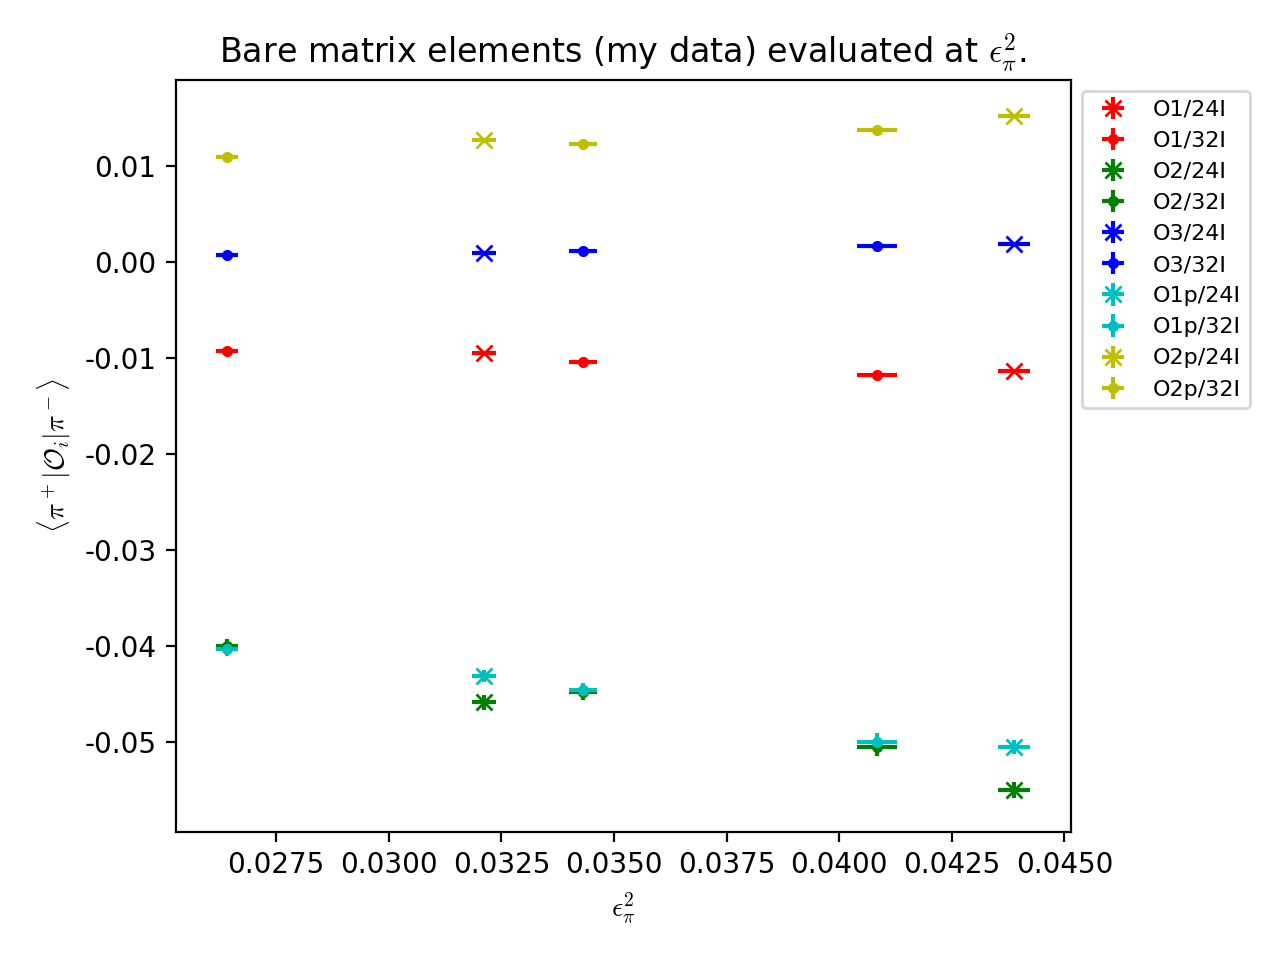

In [17]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
markers = ['v', 'v', '.', '.', '.']
plt.figure()
for i in range(n_ops):
#     plt.errorbar(eps_phys_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
#     plt.errorbar(eps_phys_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
    plt.errorbar(eps_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
    plt.errorbar(eps_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('$\\langle \pi^+ | \mathcal{O}_i | \pi^- \\rangle$')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
# plt.xlim((0.025, 0.045))
# plt.ylim((0.015, 0.029))
# plt.title('Renormalized matrix elements evaluated at $\epsilon_\pi^2|_{f_0}$.')
plt.title('Bare matrix elements (my data) evaluated at $\epsilon_\pi^2$.')
plt.tight_layout()
plt.show()

## Perform the fit

In [18]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)
# this mirrors David's code, but it should be a bug: inputs L = 32 for the f1 piece regardless of ensemble.
#     if op_idx == 2:    # for O3
#         return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, 32, ainv)
#     return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, 32, ainv)

In [19]:
# Define functional fit forms for the operators (these agree with David's functions)
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

In [20]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3


KeyboardInterrupt: 

In [ ]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

#### Fit to full data

In [ ]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

#### Print mean and std for bootstrapped fit parameters

In [ ]:
# chi2_boots[0].compute_mean() / 2

In [ ]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

#### Get error on data and print subtracted matrix elements

In [ ]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

In [ ]:
colors = ['limegreen', 'deepskyblue', 'r', 'g', 'midnightblue']

In [ ]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']
plt.figure()
for j in range(n_ops):
    plt.errorbar(eps_sq_sub_mu, mat_elems_sub_mu[j], xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                 c = colors[j], fmt = '.', label = labels[j])
    plt.fill_between(epsilon_sq_range[1:], band_data_mu[j] + band_data_sigma[j], band_data_mu[j] - band_data_sigma[j], \
                    color = colors[j], alpha = 0.3)
plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')
plt.legend(loc = 'lower right')
plt.xlim((0.0, 0.16))
plt.ylim((-0.08, 0.02))
plt.title('Chiral extrapolation of renormalized matrix elements.', fontsize = 16)
# plt.xlabel('$\epsilon^2 = m_\pi^2 / 8\pi^2\Lambda_\chi^2$', fontsize = 18)
plt.xlabel('$\epsilon^2 = m_\pi^2 / 16\pi^2\Lambda_\chi^2$', fontsize = 18)
# for some reason matplotlib breaks when we use \rangle in latex?
plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_i \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = 18)
plt.tight_layout()
plt.show()

In [ ]:
eps_sq_phys_ens

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/chiral_extrap/renorm_ZVeq1.pdf')

## Notes

RESULTS FOR FITS TO THE MEAN

I generated fake data based on David's results for mpi and fpi and put them through the function which fits to their means-- it got pretty close to the values that his actual code spits out, when the L value was set to 32 each time. When I corrected the code it was still pretty close to what he had. Here's what David's code spits out:
O1
[-1.3102490330637617, -1.7066608393579843, -0.8422449312953697]
O2
[10.175257387129525, -4.966574781162899, -1.1703248819465772]
O3
[51.5038664286794, 0.6004464229091153, 1.7476029824455277]
O1p
[-1.5315739501273549, -5.489990421744237, -1.0860719237531953]
O2p
[7.343578513224973, 1.2660260632687053, -1.1274407384203236]

Here are the results from my code, using David's numbers to generate fake data, with L = 32 everywhere:
O1
[-1.20250871 -1.699562   -0.85025151]
O2
[10.24026743 -4.94628411 -1.17843114]
O3
[51.17464927  0.60353138  1.60246262]
O1p
[-1.44404244 -5.47414468 -1.10505762]
O2p
[ 7.44079538  1.26197142 -1.11098124]

And here are the results of my code, using David's numbers to generate fake data, with the correct value of L
O1
[-1.47760682 -1.6985531  -0.81686195]
O2
[ 9.98126654 -4.94366356 -1.14693482]
O3
[51.47078419  0.60335902  1.58085964]
O1p
[-1.71935554 -5.47075782 -1.07157295]
O2p
[ 7.17470892  1.26197194 -1.08468667]


Finally, if I use my data (with the correct value of L), I get a very different result. This is likely due to the fact that my fpi fits seem to give pretty different results-- need to check these and see what's going on. In the raw data, notice how the epsilon^2 values seem to be pretty different.
O1
[-7.16650898 -1.72766092 -0.17137882]
O2
[ 3.19326516 -4.9742111  -0.27528603]
O3
[43.60165803  0.63308699  1.39549587]
O1p
[-7.2709804  -5.5523971  -0.41884921]
O2p
[ 0.65288339  1.27018767 -0.2876572 ]

RESULTS FOR FITS TO THE FULL DATA WITH STATISTICS
David's numbers are in the notes he gave me. For the fake data, I generated fake ensembles with his numbers. I've saved plots from the chiral extrapolation in the folder research/0nubb/short_distance/chiral_extrap.

Results from my code using David's numbers to generate fake data, with L = 32 in f1: The plot for this is called 'david_data_buggy_code.pdf'. 
Fit parameters for operator O1
alpha = -1.1952923105750501 \pm 2.4232318685016687
beta = -1.6994125525843942 \pm 0.06894923313114809
c = -0.8478857721620399 \pm 0.42561839796501455
Fit parameters for operator O2
alpha = 10.25607199144804 \pm 3.237465976998419
beta = -4.945760266098866 \pm 0.25418046037910413
c = -1.1746486380349297 \pm 0.5360807050000578
Fit parameters for operator O3
alpha = 51.18682468116901 \pm 2.5406990329994716
beta = 0.6034953545922799 \pm 0.014862089003006899
c = 1.605380169186574 \pm 0.5921588562456657
Fit parameters for operator O1p
alpha = -1.437061479029064 \pm 2.36737668643327
beta = -5.4736652066393034 \pm 0.2175374717957628
c = -1.102885781343092 \pm 0.40934025689340536
Fit parameters for operator O2p
alpha = 7.442395660837931 \pm 0.6403661895226712
beta = 1.2619134184055125 \pm 0.014275051766372084
c = -1.1107447831821937 \pm 0.12393024098384445
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017695036164755037 \pm 0.00067868856980416
<pi|O2|pi> = -0.05122880377975424 \pm 0.002460141490902251
<pi|O3|pi> = 0.00011926473572161716 \pm 2.338028050502914e-06
<pi|O1p|pi> = -0.056763155854780624 \pm 0.0021450279659343215
<pi|O2p|pi> = 0.013084976490316787 \pm 0.00016967111307890042

Results from my code using David's numbers to generate fake data, with correct value of L in f1:
Fit parameters for operator O1
alpha = -1.4703869550032955 \pm 2.4232374162785835
beta = -1.6984031457401352 \pm 0.06880340920983277
c = -0.8144999249531516 \pm 0.4253689279117576
Fit parameters for operator O2
alpha = 9.997066827141868 \pm 3.2378708235836617
beta = -4.94313880822723 \pm 0.2537642907579481
c = -1.1431567921190475 \pm 0.5359239169173328
Fit parameters for operator O3
alpha = 51.48298021930898 \pm 2.543668509271114
beta = 0.6033305797019024 \pm 0.014884661038272625
c = 1.583327493709689 \pm 0.5932071339905192
Fit parameters for operator O1p
alpha = -1.7123706627798156 \pm 2.3674259990976902
beta = -5.470277244756541 \pm 0.21706558466921363
c = -1.0694054158129125 \pm 0.40910386276330585
Fit parameters for operator O2p
alpha = 7.176317790506278 \pm 0.6397362804138845
beta = 1.2619136971513203 \pm 0.014200927008520178
c = -1.0844519824046788 \pm 0.1236139068843035
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017693920897671796 \pm 0.0006777561883768293
<pi|O2|pi> = -0.05122744422013253 \pm 0.0024576851975487896
<pi|O3|pi> = 0.00011920018637870915 \pm 2.340104008053997e-06
<pi|O1p|pi> = -0.05675836741349343 \pm 0.0021419892665343818
<pi|O2p|pi> = 0.013090476037653698 \pm 0.00016916232505704334

Results from my code using my data, with correct value of L in f1:
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01817977862601922 \pm 0.000537991979223405
<pi|O2|pi> = -0.052255283438707084 \pm 0.0018902251284648097
<pi|O3|pi> = 0.00012479699318107833 \pm 2.5914655655857415e-06
<pi|O1p|pi> = -0.058198972660061216 \pm 0.001722408726239742
<pi|O2p|pi> = 0.01334112508669661 \pm 0.0004690395619702873

Tests with David's data: Run the full analysis by taking David's data points in the document (note that he has saved data for this, but it's jackknifed, so instead I'll just generate fake bootstrapped ensembles) with both the buggy code (the one in David's script with the wrong value of L in f1) and the corrected code. Compare to David's values for the chiral extrapolation. Also note that even with using David's data, since I'm generating a different ensemble from his data it shouldn't match exactly, but it (especially the buggy output) should match his results up to uncertainty.